In [ ]:
!pip install moku[neuralnetwork]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.4 MB/s eta 0:00:00


# Moku:Go Neural Network – Weighted Sum of Two Inputs

In this example, we will train a basic neural network model to output a **weighted sum of two input channels** with an optional bias (offset) term, using a single layer with a single neuron and a linear activation.

We will be using the **Moku:Go** Neural Network instrument. Since Moku:Go can handle a maximum of two channels at a time, this example focuses on adding **2 signals** together:

$$
\text{out} = \text{amp}_1 \cdot \text{in1} + \text{amp}_2 \cdot \text{in2} + \text{offset}
$$

We will:

1. Generate input (2 channels) and output (1 channel) data for training.
2. Define and train a simple linear neural network using `LinnModel`.
3. Save the trained model to a `.linn` file for use with the Moku Neural Network instrument.
4. Discuss how to implement and verify this on the Moku:Go.


 ## Step 1: Generate Input and Output Data for training

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Import Moku neural network helpers
try:
    from moku.nn import LinnModel, save_linn
except ImportError:
    print("Moku library is not installed.")
    print("If you're in Colab, run:  !pip install moku[neuralnetwork]")
    raise

# Optional: for repeatable results
np.random.seed(42)

# Make plots appear inline (Colab usually does this by default)
%matplotlib inline

/usr/local/lib/python3.12/dist-packages/moku/__init__.py:27: UserWarning: Can't find mokucli, which is required for correct operation. Please install from https://liquidinstruments.com/software/utilities/ or set the MOKU_CLI_PATH environment variable to the path of the mokucli executable. Using default path.
  warnings.warn("Can't find mokucli, which is required for correct operation. Please install from https://liquidinstruments.com/software/utilities/ or set the MOKU_CLI_PATH environment variable to the path of the mokucli executable. Using default path.")


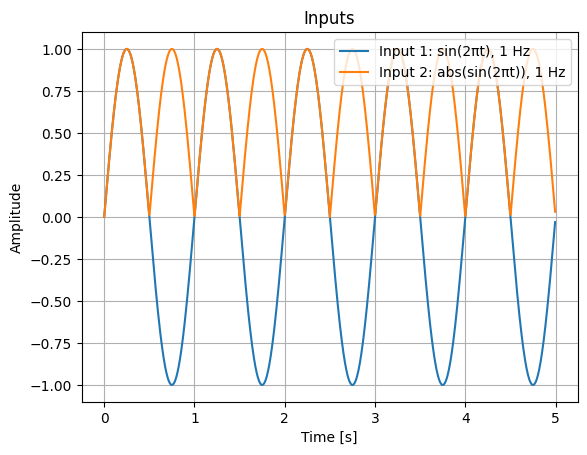

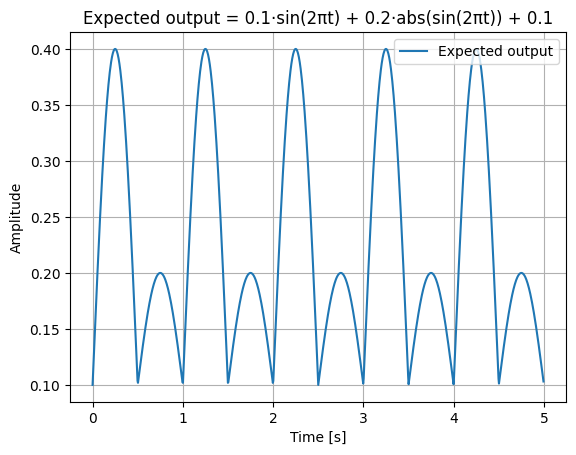

In [ ]:
# Step 1: Generate input (2 channels) and output (1 channel) data for training

nPts = 1024
nCycles = 5
f = 1.0

# Time vector: nCycles of a 1 Hz waveform -> total duration = 5 seconds
t = np.linspace(0, nCycles / f, nPts, endpoint=False)

# Input channel 1: 1 Hz sine wave
in1 = np.sin(2 * np.pi * f * t)

# Input channel 2: 1 Hz full-wave rectified sine wave
in2 = np.abs(np.sin(2 * np.pi * f * t))

# Weights and offset used to generate the expected output
offset = 0.1
amp1 = 0.1
amp2 = 0.2

# Expected output (target for training)
out = amp1 * in1 + amp2 * in2 + offset

# Plot the inputs
plt.figure()
plt.plot(t, in1, label="Input 1: sin(2πt), 1 Hz")
plt.plot(t, in2, label="Input 2: abs(sin(2πt)), 1 Hz")
plt.title("Inputs")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.grid(True)

# Plot the expected output
plt.figure()
plt.plot(t, out, label="Expected output")
plt.title("Expected output = 0.1·sin(2πt) + 0.2·abs(sin(2πt)) + 0.1")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

## Step 2: Define the model and train the neural network

A neural network is composed of successive layers of connected neurons.  
Each neuron typically implements a transformation of the form:

$$
A(Wx + b)
$$

where:

- $W$ is the weight matrix,
- $x$ is the input vector,
- $b$ is the bias vector,
- $A$ is the activation function.

By stacking many such neurons and layers, a neural network becomes a universal approximator.  
The Moku FPGA currently supports *densely connected feedforward networks*.

In this example, we keep things simple:

- **Inputs**: 2 channels (`in1`, `in2`)
- **Output**: 1 channel (`out`)
- **Model**: single dense layer, with a **single neuron** and a **linear** activation function.

We represent the model structure as a list of tuples:

```python
model_definition = [(1, "linear")]


To experiment with different models,  replace the current `model_definition` with **one** of the alternative definitions provided in the comments, or create your own! The number of tuples determines the number of layers (maximum of 5 on the Moku:Go), while the tuple values define the layer width (maximum 50) and the activation function (Supported: `["relu", "tanh", "sigmoid", "softsign", "linear"]`).

In [ ]:
# Step 2: Define the model and train the neural network

# Reshape the inputs, ready for training.
# Each data point consists of two inputs (in1, in2) and one output.
inputs = np.vstack((in1, in2)).T      # shape: (nPts, 2)
out.shape = [nPts, 1]                 # shape: (nPts, 1)

# Create the LinnModel and set the training data.
linn_model = LinnModel()
linn_model.set_training_data(inputs, out, scale=False)

# Define a simple single-layer linear model
# A linear model should give an excellent prediction in this case.
model_definition = [(1, "linear")]

# Alternative model definitions to experiment with:
# model_definition = [(4, "relu"), (4, "relu")]
# model_definition = [(4, "tanh"), (4, "tanh")]
# model_definition = [(50, "tanh"), (50, "tanh"), (50, "tanh"), (50, "tanh"), (50, "tanh")]

# Build the neural network model
linn_model.construct_model(model_definition)

Epoch 1/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2392 - val_loss: 0.4958
Epoch 2/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2335 - val_loss: 0.4935
Epoch 3/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2357 - val_loss: 0.4890
Epoch 4/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2216 - val_loss: 0.4829
Epoch 5/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.2104 - val_loss: 0.4761
Epoch 6/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2220 - val_loss: 0.4661
Epoch 7/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.2031 - val_loss: 0.4566
Epoch 8/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2049 - val_loss: 0.4452
Epoch 9/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2108 - val_loss: 0.4329
Epoch 10/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1943 - val_loss: 0.4183
Epoch 11/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1894 - val_loss: 0.3998
Epoch 12/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - 

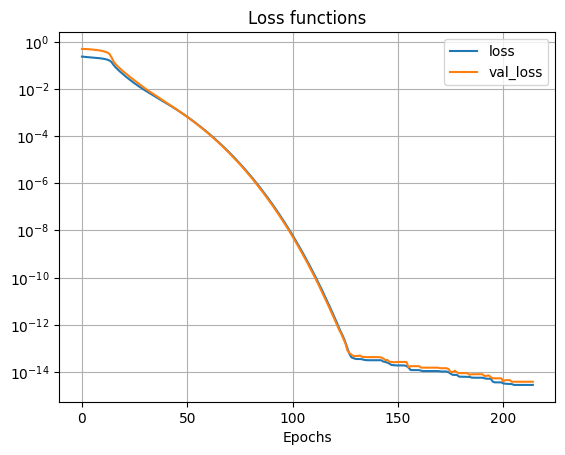

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [ ]:
# Train the model. This simple model converges quickly, so early stopping is used to terminate training much earlier than the max epoch count.
history = linn_model.fit_model(
    epochs=500,
    validation_split=0.1,
    es_config={"patience": 10}
)

# Plot the training and validation loss
plt.figure()
plt.semilogy(history.history["loss"], label="loss")
plt.semilogy(history.history["val_loss"], label="val_loss")
plt.legend()
plt.xlabel("Epochs")
plt.title("Loss functions")
plt.grid(True)
plt.show()

# Use the trained model to predict on the inputs
nn_out = linn_model.predict(inputs)

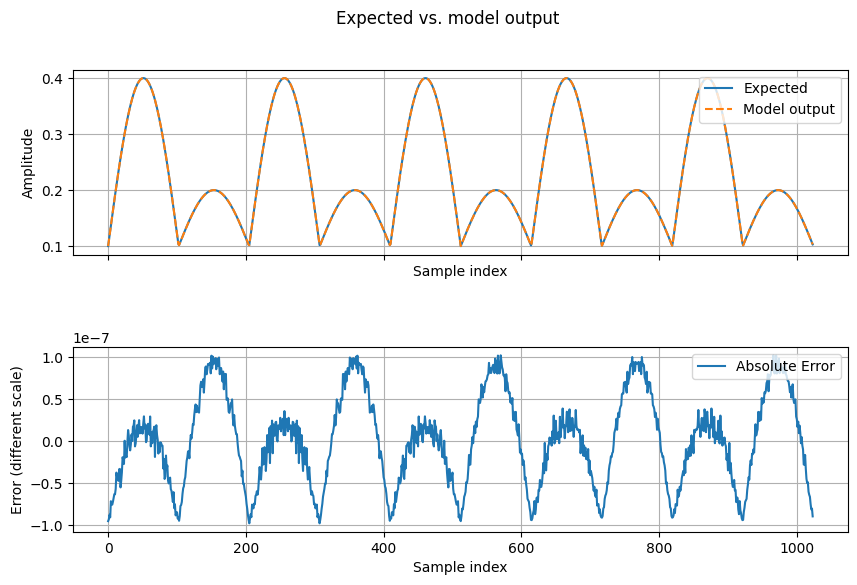

Mean Absolute Error (MAE) ≈ 4.424e-08


In [ ]:
# Compute error
error = nn_out - out

# Plot the expected vs. predicted and the error
fig, axs = plt.subplots(2, figsize=(10, 6), sharex=True)
fig.suptitle("Expected vs. model output")

# Top: outputs
axs[0].plot(out, label="Expected")
axs[0].plot(nn_out, "--", label="Model output")
axs[0].set_ylabel("Amplitude")
axs[0].set_xlabel("Sample index")
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Bottom: error
axs[1].plot(error, label="Absolute Error")
axs[1].set_ylabel("Error (different scale)")
axs[1].set_xlabel("Sample index")
axs[1].legend(loc='upper right')
axs[1].grid(True)

# Use the same y-limits as the top plot so we can see how small the error is relative to the signal amplitude
# ymin, ymax = axs[0].get_ylim()
# axs[1].set_ylim(ymin, ymax)

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

# Compute Mean Absolute Error (MAE) for reference
mae = np.mean(np.abs(error))
print(f"Mean Absolute Error (MAE) ≈ {mae:.3e}")

Please **note** the difference in the scale of the two graphs. The error is on a scale of **1e-7**.

## Step 3: Save the trained model to a .linn file for use with the Moku Neural Network instrument.

In [ ]:
# Step 3: Save the model to a .linn file

save_linn(linn_model.model, input_channels=2, output_channels=1, file_name="Sum.linn")

print("Model saved to 'Sum.linn'")

Model saved to 'Sum.linn'


Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 5 cycles


## Implementation on the Moku:Go

In this step, we deploy the trained neural network onto the **Moku:Go** and verify that the hardware output matches our simulated result.

---

### MultiInstrument configuration

1. Launch **Multi-Instrument** mode on the Moku:Go.
2. Add the following instruments to the Multi-Instrument chain:
   - **Arbitrary Waveform Generator (AWG)**
   - **Neural Network**
   - **Oscilloscope**

Configure the connections so that:

- AWG Channel A → Neural Network Input A  
- AWG Channel B → Neural Network Input B  
- Neural Network Output → Oscilloscope Channel A

![Moku:Go MultiInstrument setup](https://drive.google.com/uc?export=view&id=1cIqe8OkZK6Am8gUMCof_DWY1Mgoc1X9v)
---

### Configure the AWG

For our example we use **1 Hz** signals, which is below the Nyquist frequency of the Neural Network instrument.

Choose two input waveforms such as:

- Channel A: `sin(2*pi*t)`  
- Channel B: `abs(sin(2*pi*t))`

Set both to 1 Hz and suitable amplitudes (e.g., 1 Vpp) so they match the ranges used when generating the training data.

**Remember** to sync the phases of the generated waveforms by clicking on the setup button on the bottom right corner.

![Waveform generator configuration](https://drive.google.com/uc?export=view&id=1yPejnOx_fehgoxXJqpCJBE3BWafsn7e9)
---

### Load the `.linn` model into the Neural Network

1. Export or copy the `Sum.linn` file from your notebook environment to the Moku:Go.
2. In the Neural Network instrument:
   - Load the `Sum.linn` file.
   - Ensure **2 inputs** and **1 output** are shown.

The neural network now computes approximately:

$$
\text{out}(t) \approx 0.1 \cdot \text{in1}(t) + 0.2 \cdot \text{in2}(t) + 0.1
$$

![Neural Network configuration](https://drive.google.com/uc?export=view&id=1NQ1EhLLhORBEj91vtkgvdny66YzI-5Hv)

3. Visualize the output in the Oscilloscope:

![NN Oscilloscope Output](https://drive.google.com/uc?export=view&id=1iPfG2Z_3ebVjLjfjz77Vg46IWZFGs47D)
---

### Reference output using the oscilloscope Math Channel

To generate a theoretical reference, we can use the Oscilloscope’s **Math Channel**:

- Assign:
  - Channel A → input wave 1
  - Channel B → input wave 2
- Configure the Math Channel with the expression:

$$
0.1*A + 0.2*B + 0.1
$$

![Oscillscope Math Output](https://drive.google.com/uc?export=view&id=1g0RTBnZXLWjvpB8R7MzBVrLL8N8Pfqv7)